In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models import MobileNetV3
from torchvision import transforms
from torchvision.datasets import GTSRB
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/mobilenet")
data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

5


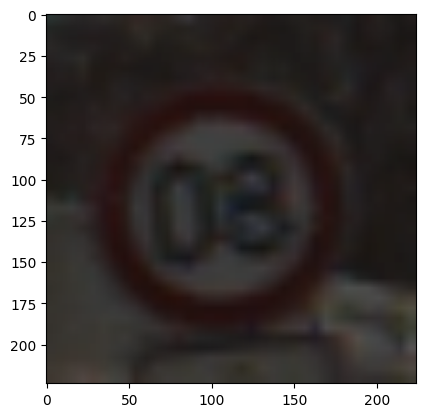

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = MobileNetV3(output_size=num_class).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
MobileNetV3                                                       --
├─Sequential: 1-1                                                 --
│    └─Conv2dNormActivation: 2-1                                  --
│    │    └─Conv2d: 3-1                                           432
│    │    └─BatchNorm2d: 3-2                                      32
│    │    └─Hardswish: 3-3                                        --
│    └─InvertedResidualBlockV3: 2-2                               --
│    │    └─ResBlock: 3-4                                         752
│    └─InvertedResidualBlockV3: 2-3                               --
│    │    └─LinearBottleneckV3: 3-5                               3,440
│    └─InvertedResidualBlockV3: 2-4                               --
│    │    └─ResBlock: 3-6                                         4,440
│    └─InvertedResidualBlockV3: 2-5                               --
│    │    └─LinearBot

# training

In [13]:
epoches = 10
acc_iters = 256 // BATCH_SIZE

In [14]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [17]:
training_loss = trainer.run(train_loader, model, optim, criterion)

  0%|          | 0/416 [00:00<?, ?it/s]

100%|██████████| 416/416 [01:40<00:00,  4.14it/s]


epoch 1: 0.012902876772769578


100%|██████████| 416/416 [01:36<00:00,  4.32it/s]


epoch 2: 0.0068724783210156555


100%|██████████| 416/416 [01:30<00:00,  4.62it/s]


epoch 3: 0.002540329046821496


100%|██████████| 416/416 [01:10<00:00,  5.94it/s]


epoch 4: 0.000880475010332727


100%|██████████| 416/416 [01:10<00:00,  5.88it/s]


epoch 5: 0.00042438101956506147


100%|██████████| 416/416 [01:12<00:00,  5.73it/s]


epoch 6: 0.0002982446961258692


100%|██████████| 416/416 [01:08<00:00,  6.06it/s]


epoch 7: 0.00020464053375979636


100%|██████████| 416/416 [01:07<00:00,  6.18it/s]


epoch 8: 0.00019539205486607925


100%|██████████| 416/416 [01:07<00:00,  6.17it/s]


epoch 9: 0.00014004803215684987


100%|██████████| 416/416 [01:07<00:00,  6.16it/s]

epoch 10: 0.00014377921628851414


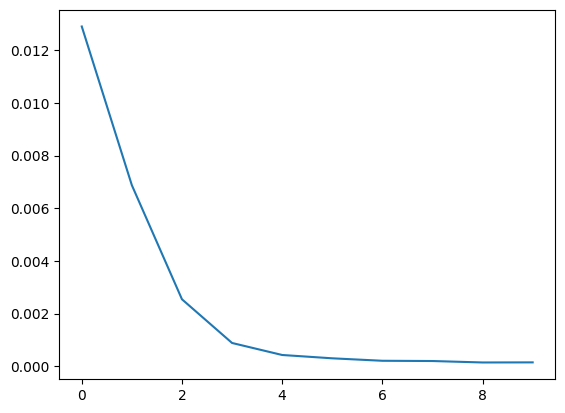

In [18]:
plt.plot(training_loss)

# inference

In [19]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [20]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [21]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [22]:
evaluator = ClassificationEvaluator(num_class, device)

In [23]:
confusion_matrix = IncrementalConfusionMatrix(num_class)

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)
        
        output = model(img)
        output = output.detach().cpu()

        output = output.argmax(dim=1)
        confusion_matrix.update(label, output)

100%|██████████| 198/198 [02:06<00:00,  1.56it/s]


In [24]:
print(confusion_matrix)

[[ 60   0   0 ...   0   0   0]
 [  1 708   7 ...   0   0   0]
 [  0   1 743 ...   0   0   0]
 ...
 [  0   0   0 ...  84   0   0]
 [  0   0   0 ...   0  54   3]
 [  0   0   0 ...   0   3  85]]


In [25]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 1.0
1         : 0.9833333333333333
2         : 0.9906666666666667
3         : 0.9755555555555555
4         : 0.9606060606060606
5         : 0.926984126984127
6         : 0.88
7         : 0.94
8         : 0.9177777777777778
9         : 0.9895833333333334
10        : 0.9939393939393939
11        : 0.9833333333333333
12        : 0.9173913043478261
13        : 0.9916666666666667
14        : 1.0
15        : 0.9476190476190476
16        : 1.0
17        : 0.9916666666666667
18        : 0.7384615384615385
19        : 0.75
20        : 0.8444444444444444
21        : 0.6333333333333333
22        : 0.9416666666666667
23        : 0.9333333333333333
24        : 0.9777777777777777
25        : 0.9729166666666667
26        : 0.9944444444444445
27        : 0.4666666666666667
28        : 0.9333333333333333
29        : 0.7888888888888889
30        : 0.74
31        : 0.8925925925925926
32        : 1.0
33        : 0.8857142857142857
34        : 0.6833333333333333
35        : 0.9692307692307692
3

In [26]:
per_class_acc.mean()

0.8908753058909782

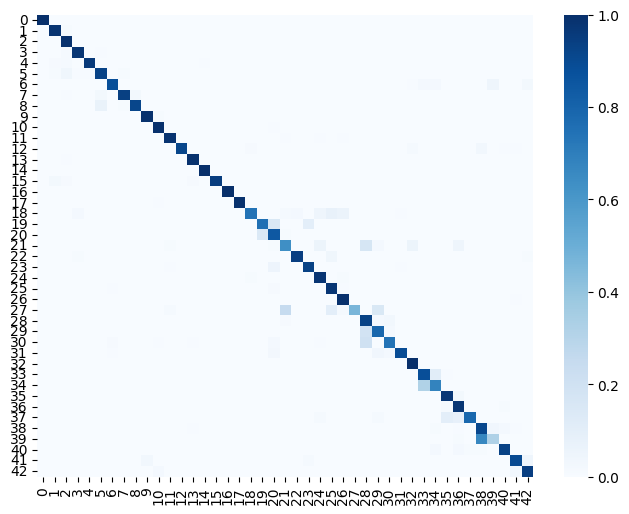

In [27]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [28]:
model_path = artifact_path / f'mobilenetV3.large.pth'

In [29]:
torch.save(model.state_dict(), model_path)

In [30]:
get_file_size(model_path)

'18.25MB'

In [31]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>